In [1]:
import cv2
import numpy as np
import pandas as pd
from Misc.utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import argparse
import imutils
import random
import math
from scipy.interpolate import interp2d
import os
import dlib

In [2]:
def FaceDetector(grayFace, box, FacePredictor):
    # pass the image and the bounding box to get face landmarks
    facemarks = FacePredictor(grayFace,box)
    facemarks = toNumpy(facemarks)
    BoundingBox = getcv2Box(box)
    (x,y,w,h) = BoundingBox
    shifted_FaceMarks = facemarks - (x,y)                
    return facemarks, BoundingBox, shifted_FaceMarks

def drawMarkers(Face1, facemarks, box):    
    Face = Face1.copy()
    (x,y,w,h) = box
    cv2.rectangle(Face,(x,y),(x+w,y+h),(0,255,0),2)
    
    for (a,b) in facemarks:
        cv2.circle(Face,(a,b),2,(255,0,0),-1)
    return Face


In [3]:
def ThinPlateKernalFunc(set1, set2):
    # r = np.abs(set1[0] -  set2[0]) + np.abs(set1[1] - set2[1])
    r = np.linalg.norm((np.array(set1) - np.array(set2)))
    U = (r**2) * np.log(r**2)
    if r == 0:
        U = 0
    return U


In [4]:
def getParameters(set1, set2):
    p = set2.shape[0]
    K = np.zeros((p, p))
    P = np.zeros((p, 3))

    for i in range(p):
        for j in range(p):
            K[i,j] = ThinPlateKernalFunc([set2[i, 0], set2[i, 1]], [set2[j, 0], set2[j, 1]])

        P[i, 0] = set2[i, 0]
        P[i, 1] = set2[i, 1]
        P[i, 2] = 1

    L = np.zeros((p + 3, p + 3))
    L[0:p, 0:p] = K
    L[0:p, p:p + 3] = P
    L[p:p + 3, 0:p] = np.transpose(P)

    L = L + np.eye(p + 3) * 1e-10
    L_inv = np.linalg.inv(L)

    set1x_dash = np.zeros((set1.shape[0] + 3, 1))
    set1y_dash = np.zeros((set1.shape[0] + 3, 1))

    set1x_dash[0:set1.shape[0], :] = set1[:,0].reshape(-1,1)
    set1y_dash[0:set1.shape[0], :] = set1[:,1].reshape(-1,1)

    Mx = np.dot(L_inv, set1x_dash)
    My = np.dot(L_inv, set1y_dash)

    return np.hstack((Mx, My))


In [5]:
def warpFaces(face1, face2, M, face_markers_2):
    Mx = M[:, 0].reshape(-1,1)
    My = M[:, 1].reshape(-1,1)

    Xi, Yi = np.indices((face2.shape[1], face2.shape[0])) 
    warped_points = np.stack((Xi.ravel(), Yi.ravel(), np.ones(Xi.size))).T

    axx = Mx[Mx.shape[0] - 3]
    ayx = Mx[Mx.shape[0] - 2]
    a1x = Mx[Mx.shape[0] - 1]

    axy = My[My.shape[0] - 3]
    ayy = My[My.shape[0] - 2]
    a1y = My[My.shape[0] - 1]

    A = np.array([[axx, axy], [ayx, ayy], [a1x, a1y]]).reshape(3,2)
    actual_points = np.dot(warped_points, A) 

    warped_points_x = warped_points[:,0].reshape(-1,1)
    face_markers_2_x = face_markers_2[:,0].reshape(-1,1)
    ax, bx = np.meshgrid(face_markers_2_x, warped_points_x)
    t1 = np.square(ax - bx)

    warped_points_y = warped_points[:, 1].reshape(-1,1)
    face_markers_2_y = face_markers_2[:, 1].reshape(-1,1)
    ay, by = np.meshgrid(face_markers_2_y, warped_points_y)
    t2 = np.square(ay - by)

    R = np.sqrt(t1 + t2)
    U = np.square(R) * np.log(np.square(R))
    U[R == 0] = 0 #perfect"

    MX = Mx[0:68, 0].T
    Ux = MX * U #perfect
    Ux_sum = np.sum(Ux, axis = 1).reshape(-1,1)

    MY = My[0:68, 0].T
    Uy = MY * U #perfect
    Uy_sum = np.sum(Uy, axis = 1).reshape(-1,1)

    actual_points = actual_points + np.hstack((Ux_sum, Uy_sum))

    X = actual_points[:, 0].astype(int)
    Y = actual_points[:, 1].astype(int)
    X[X >= face1.shape[1]] = face1.shape[1] - 1
    Y[Y >= face1.shape[0]] = face1.shape[0] - 1
    X[X < 0] = 0
    Y[Y < 0] = 0

    warped_face = np.zeros(face2.shape)
    print(np.max(Yi.ravel()), np.max(Xi.ravel()))
    print(np.max(Y.ravel()), np.max(X.ravel()))
    warped_face[Yi.ravel(), Xi.ravel()] = face1[Y, X]

    return np.uint8(warped_face)

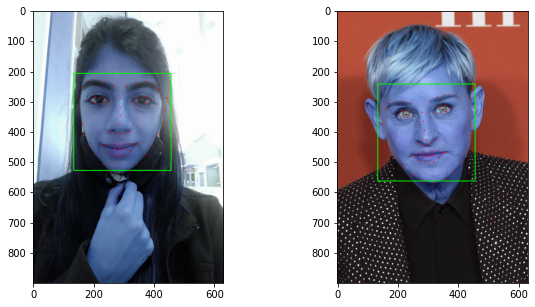

In [8]:
path_to_shape_predictor = './Misc/shape_predictor_68_face_landmarks.dat'
path_to_image = "../Data/"
path_to_image1 = path_to_image+ "SFace1.jpg"
path_to_image2 =  path_to_image + "EFace2.jpg"

Face1, Face2 = readImages(path_to_image1, path_to_image2)
grayFace1 = cv2.cvtColor(Face1, cv2.COLOR_BGR2GRAY)
grayFace2 = cv2.cvtColor(Face2, cv2.COLOR_BGR2GRAY)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_to_shape_predictor)

# get bounding box of face
N_pyrLayers = 1
box1 = detector(grayFace1,N_pyrLayers)[0]
# box2 = detector(grayFace2,N_pyrLayers)[0]
try:
    box2 = detector(grayFace2,N_pyrLayers)[0]
except IndexError as e:
    print(e)
    sys.exit(1) 

facemarks1, BoundingBox1, shifted_FaceMarks1 = FaceDetector(grayFace1, box1, predictor)
facemarks2, BoundingBox2, shifted_FaceMarks2 = FaceDetector(grayFace2, box2, predictor)

# Face1_print = drawMarkers(Face1, facemarks1, BoundingBox1)
# Face2_print = drawMarkers(Face2, facemarks2, BoundingBox2)

(x,y,w,h) = BoundingBox1
Face1_crop  = Face1[y:y+h,x:x+w]
(x,y,w,h) = BoundingBox2
Face2_crop  = Face2[y:y+h,x:x+w]

Face1_print = drawMarkers(Face1, facemarks1, BoundingBox1)
Face2_print = drawMarkers(Face2, facemarks2, BoundingBox2)

_, plts = plt.subplots(1,2,figsize=(10,5))
plts[0].imshow(Face1_print)
plts[1].imshow(Face2_print)

320 320
320 320


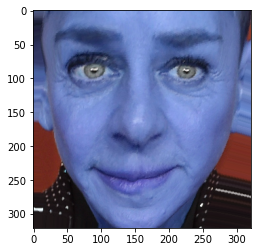

In [9]:
set1 = shifted_FaceMarks2
set2 = shifted_FaceMarks1
M  = getParameters(set1, set2)
warped_face = warpFaces(Face2_crop, Face1_crop, M, set2)
plt.imshow(warped_face)

# set1 = shifted_FaceMarks1
# set2 = shifted_FaceMarks2
# M  = getParameters(set1, set2)
# warped_face = warpFaces(Face1_crop, Face2_crop, M, set2)
# plt.imshow(warped_face)


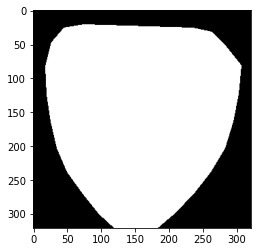

In [10]:
mask_warped_face = np.zeros(warped_face.shape, dtype = np.float32)
shifted_face1_hull = cv2.convexHull(shifted_FaceMarks1, returnPoints = True)
cv2.fillConvexPoly(mask_warped_face, np.int32(shifted_face1_hull), (255, 255, 255))
# plt.imshow(np.uint8(mask_warped_face * warped_face))
plt.imshow(np.uint8(mask_warped_face))

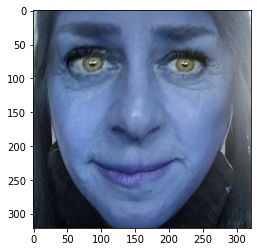

In [11]:
(x,y,w,h) = BoundingBox1
center = ((int(h/2), int(w/2)))
seamless_warped_face = cv2.seamlessClone(warped_face, Face1_crop, np.uint8(mask_warped_face), center, cv2.NORMAL_CLONE)
plt.imshow(seamless_warped_face)

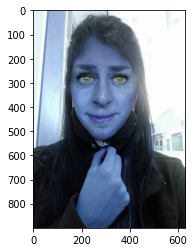

In [12]:
Face1_swaped = Face1.copy()
Face1_swaped[y:y+h,x:x+w] = seamless_warped_face
plt.imshow(np.uint8(Face1_swaped))

In [13]:
cv2.imshow("b", Face1_swaped)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imwrite("blended.png", Face1_swaped)

True

In [14]:
VideoFilePath = path_to_image+ "testvideo1.mp4"
SaveFileName = "testvideo1.avi"
cap = cv2.VideoCapture(VideoFilePath)
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4))
result = cv2.VideoWriter(SaveFileName,  
                        cv2.VideoWriter_fourcc(*'MJPG'), 
                        10, (300, 500)) 
N_pyrLayers = 1

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_to_shape_predictor)

#for warping
set1 = shifted_FaceMarks2

while(True):
    
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    frame = cv2.resize(frame, (300, 500))
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    boxFrame = detector(grayFrame, N_pyrLayers)
    if len(boxFrame) > 0:
        boxFrame = boxFrame[0]
        FaceMarksFrame, BoundingBoxFrame, shifted_FaceMarksFrame = FaceDetector(grayFrame, boxFrame, predictor)
        (xf, yf, wf, hf) = BoundingBoxFrame
        FaceFrameCrop  = frame[yf:yf+hf, xf:xf+wf]
        FaceFrame_print = drawMarkers(frame, FaceMarksFrame, BoundingBoxFrame)

        #warping
        set2 = shifted_FaceMarksFrame
        M  = getParameters(set1, set2)
        warped_face = warpFaces(Face2_crop, FaceFrameCrop, M, set2)
        
        #mask
        mask_warped_face = np.zeros(warped_face.shape, dtype = np.float32)
        shifted_faceframe_hull = cv2.convexHull(shifted_FaceMarksFrame, returnPoints = True)
        cv2.fillConvexPoly(mask_warped_face, np.int32(shifted_faceframe_hull), (255, 255, 255))

        #swap
        center = ((int(hf/2), int(wf/2)))
        seamless_warped_face = cv2.seamlessClone(warped_face, FaceFrameCrop, np.uint8(mask_warped_face), center, cv2.NORMAL_CLONE)

        Face_swaped = frame.copy()
        Face_swaped[yf:yf+hf,xf:xf+wf] = seamless_warped_face


    else:
        FaceFrame_print = frame

    cv2.imshow('frame', Face_swaped)
    result.write(np.uint8(Face_swaped))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
result.release() 
cv2.destroyAllWindows()


Stream ended..
